In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum

# Membuat sesi Spark
spark = SparkSession.builder \
    .appName("Weather Classification") \
    .getOrCreate()

# Membaca data dari file CSV
data = spark.read.csv('weather_classification_data.csv', header=True, inferSchema=True)

# Menampilkan 10 baris pertama
data.show(10)

# Menampilkan Missing Values
print("\nMissing Values:")
missing_values = data.select([spark_sum(col(column).isNull().cast("int")).alias(column) for column in data.columns])
missing_values.show()

+-----------+--------+----------+-----------------+-------------+--------------------+--------+------+---------------+--------+------------+
|Temperature|Humidity|Wind Speed|Precipitation (%)|  Cloud Cover|Atmospheric Pressure|UV Index|Season|Visibility (km)|Location|Weather Type|
+-----------+--------+----------+-----------------+-------------+--------------------+--------+------+---------------+--------+------------+
|       14.0|      73|       9.5|             82.0|partly cloudy|             1010.82|       2|Winter|            3.5|  inland|       Rainy|
|       39.0|      96|       8.5|             71.0|partly cloudy|                NULL|       7|Spring|           10.0|  inland|      Cloudy|
|       30.0|      64|       7.0|             16.0|        clear|             1018.72|       5|Spring|            5.5|mountain|       Sunny|
|       38.0|      83|       1.5|             82.0|        clear|             1026.25|       7|Spring|            1.0| coastal|       Sunny|
|       27.0|

In [10]:
import pandas as pd

data = pd.read_csv('weather_classification_data.csv').replace('None', pd.NA) # Membaca data dari file CSV dan mengganti 'None' dengan NaN

data['Temperature'] = pd.to_numeric(data['Temperature'], errors='coerce') # Mengubah kolom Temperature menjadi numerik

numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns # Menentukan kolom numerik

data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean()) # Mengisi nilai yang hilang dengan rata-rata

data[numeric_cols] = (data[numeric_cols] - data[numeric_cols].mean()) / data[numeric_cols].std() # Normalisasi dan standarisasi

# Menyimpan data ke file CSV
data.to_csv('normalized_standardized_weather_classification_data.csv', index=False)

# Menghitung jumlah nilai yang hilang di kolom 'Temperature'
missing_temperature = data['Temperature'].isna().sum()

# Menampilkan jumlah nilai yang hilang di kolom 'Temperature'
print(f"Jumlah nilai yang hilang di kolom 'Temperature': {missing_temperature}")
missing_values = data.isnull().sum().reset_index()
missing_values.columns = ['Column', 'Missing Values']
print("\nMissing Values:")
print(missing_values)

# Menampilkan data dalam bentuk tabel
print("\nData setelah normalisasi dan standarisasi:")
print(data)

Jumlah nilai yang hilang di kolom 'Temperature': 0

Missing Values:
                  Column  Missing Values
0            Temperature               0
1               Humidity               0
2             Wind Speed               0
3      Precipitation (%)               0
4            Cloud Cover               0
5   Atmospheric Pressure               0
6               UV Index               0
7                 Season               0
8        Visibility (km)               0
9               Location               0
10          Weather Type               0

Data setelah normalisasi dan standarisasi:
       Temperature  Humidity  Wind Speed  Precipitation (%)    Cloud Cover  \
0        -0.294486  0.213347   -0.046920           0.888102  partly cloudy   
1         1.144470  1.352699   -0.191825           0.543876  partly cloudy   
2         0.626446 -0.232487   -0.409183          -1.177253          clear   
3         1.086912  0.708717   -1.206164           0.888102          clear   
4     

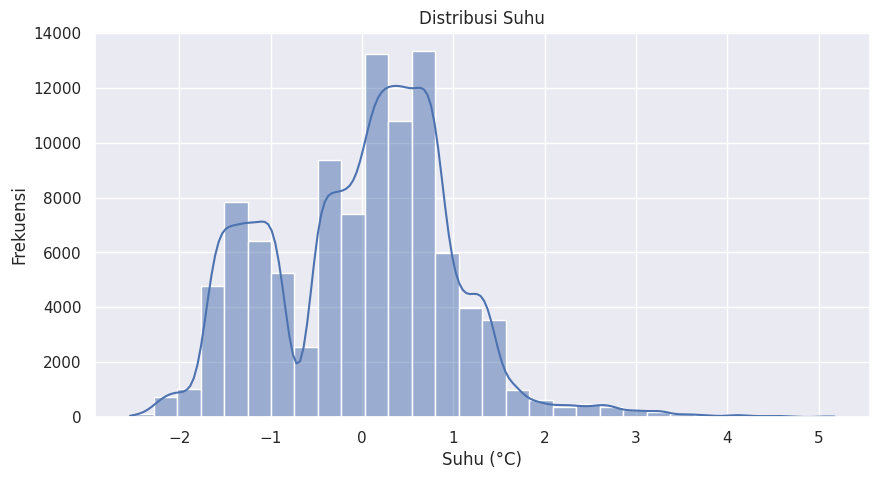

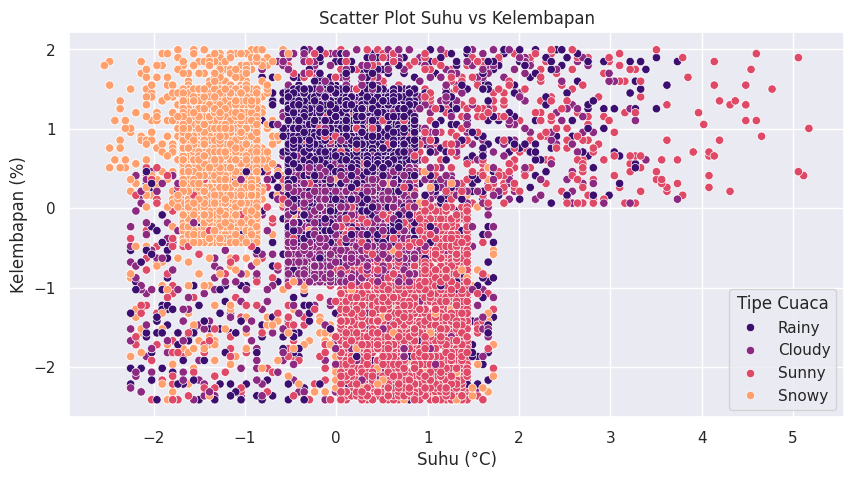

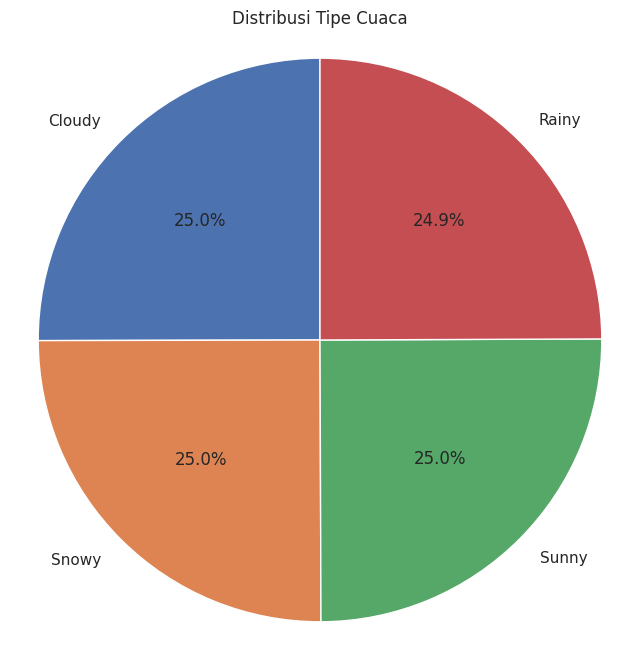

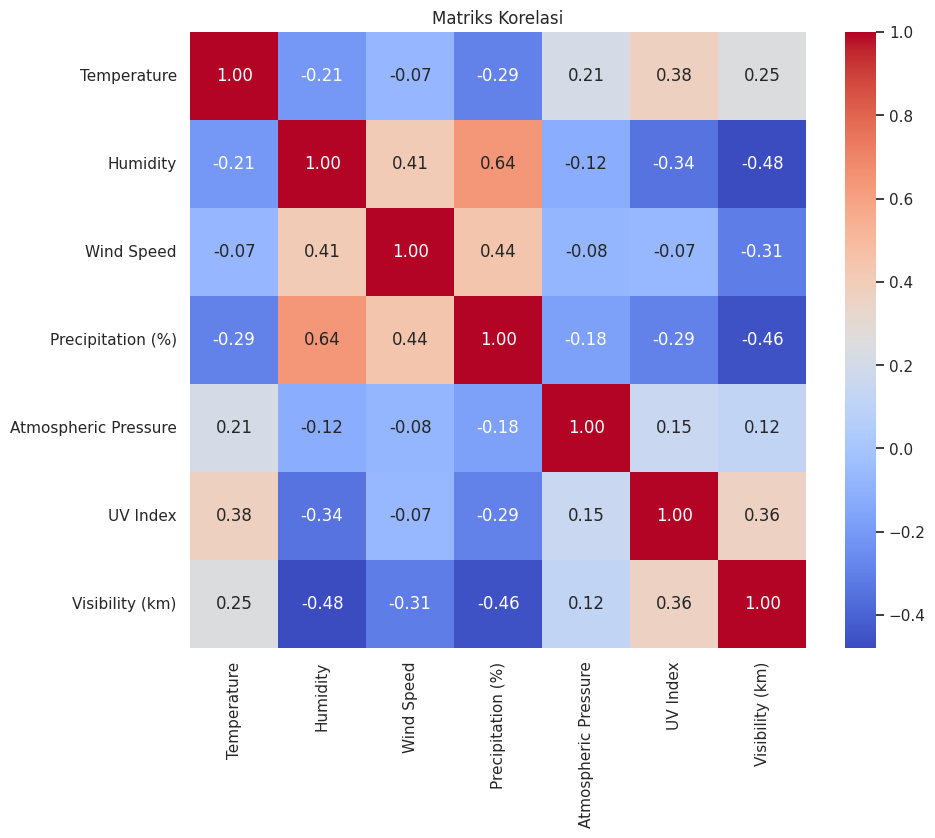

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Membaca data dari file CSV
data = pd.read_csv('normalized_standardized_weather_classification_data.csv')

# Mengatur gaya visualisasi
sns.set(style="darkgrid")

# Histogram dari suhu
plt.figure(figsize=(10, 5))
sns.histplot(data['Temperature'], bins=30, kde=True)
plt.title('Distribusi Suhu')
plt.xlabel('Suhu (°C)')
plt.ylabel('Frekuensi')
plt.show()

print()

# Scatter plot antara Suhu dan Kelembapan
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Temperature', y='Humidity', hue='Weather Type', data=data, palette='magma')
plt.title('Scatter Plot Suhu vs Kelembapan')
plt.xlabel('Suhu (°C)')
plt.ylabel('Kelembapan (%)')
plt.legend(title='Tipe Cuaca')
plt.show()

print()

# Pie chart untuk distribusi Tipe Cuaca
plt.figure(figsize=(8, 8))
weather_counts = data['Weather Type'].value_counts()
plt.pie(weather_counts, labels=weather_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Tipe Cuaca')
plt.axis('equal')  # Membuat pie chart menjadi lingkaran
plt.show()

print()

# Analisis Korelasi (hanya untuk kolom numerik)
numeric_data = data.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(10, 8))
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matriks Korelasi')
plt.show()

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Membaca data
data = pd.read_csv('weather_classification_data.csv').replace('None', pd.NA).dropna()

# Menggunakan fitur numerik untuk memprediksi suhu
X = pd.get_dummies(data.drop('Temperature', axis=1), drop_first=True)
y = data['Temperature']

# Membagi data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Membuat dan melatih model regresi
model = RandomForestRegressor(random_state=42).fit(X_train, y_train)

# Memprediksi dan mengevaluasi model
y_pred = model.predict(X_test)
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}')
print(f'R^2 Score: {r2_score(y_test, y_pred):.2f}')

# Memprediksi suhu baru
new_data = pd.get_dummies(pd.DataFrame({
    'Humidity': [70],
    'Wind Speed': [10],
    'Precipitation (%)': [20],
    'Cloud Cover': ['partly cloudy'],
    'Atmospheric Pressure': [1015],
    'UV Index': [5],
    'Season': ['Summer'],
    'Visibility (km)': [10],
    'Location': ['inland']
}), drop_first=True).reindex(columns=X.columns, fill_value=0)

predicted_temperature = model.predict(new_data)
print(f'Prediksi Suhu: {predicted_temperature[0]:.2f} °C')

Mean Squared Error: 0.06
R^2 Score: 1.00
Prediksi Suhu: 19.44 °C
